In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph with navigation information

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4042418779,0],
    [0.79950060287,0], 
    [1.10492779947,0],
    [1.25764139777,0],
    [1.27560770345,0],
    [1.527135983,0],
    [1.69781588699,0], 
    [2.03019254211,0],
    [2.16493983473,0],
    [2.34460289155,0],
    [3.0093562018,0],
    [3.27885078704,0], 
    [3.36868231545,0],
    [4.06038508422,0],
    [4.06936823706,0], 
    [4.4915764206,0],
    [4.54547533765,0],
    [4.68022263026,0], 
    [5.04853189675,0],
    [5.2102286479,0],
    [5.68633574848,0],
    [6.1354933906,0],
    [6.5846510326,0], 
] 


# for each edge (between above coordinates) specify the depth (m)
depths = [
            7.5, 4.18, 4.18, 7.83,7.83, 
            7.5, 6.5, 10.6, 6.45, 8.04,
            8.04, 5.65, 8.87, 8.87, 4.93,
            4.93, 7.7,7.7, 9.8, 5.45, 5.45,5.45, 5.45
         ] # [m]

current_speeds = [
                    -2.24* 0.2777, -3.4* 0.2777, -4.93* 0.2777, -2.59* 0.2777, -2.59* 0.2777,
                    -3.26* 0.2777, -3.85* 0.2777, -1.87* 0.2777, -1.08* 0.2777, -2.83* 0.2777, 
                    -2.83* 0.2777, -4.99* 0.2777,  -2.89* 0.2777,  -2.89* 0.2777, -6.4* 0.2777,
                    -6.4* 0.2777, -3.42* 0.2777, -3.42* 0.2777, -1.64* 0.2777, -4.1* 0.2777, -4.1* 0.2777,-4.1* 0.2777, -4.1* 0.2777
                ]  # [m/s]

V_g_profile_up = [
                    3.33, 3.33, 3.33, 3.33, 3.33,   
                    3.33, 3.33, 3.33, 3.33, 3.33,
                    3.33, 3.33, 3.33, 3.33, 3.33,
                    3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33
                ] # [m/s] for upstream, 3.33 m/s = 12 km/h

V_g_profile_down = [
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 3.33, 4.44, 4.44, 4.44, 4.44
                    ] # [m/s] for downstream, 4.44 m/s = 16 km/h


# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

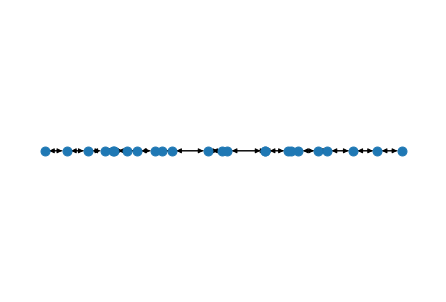

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

### Define the path 7 on the graph for energy use simulation

In [5]:
path_down_7_Regensburg2Budapest = nx.dijkstra_path(FG, nodes[0].name, nodes[23].name)

### Create vessel sailing on path 7 - add VesselProperties and ConsumesEnergy mixins

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

vessels sailing on path 7 include 17 vessel types sailing downstream loaded and ballast

In [7]:
# Create a dict with all important settings

data_vessel_MCV135_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV135_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 135,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1800,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [8]:
# Create a dict with all important settings

data_vessel_MCV135_down_ballast = {
    "env": None,
    "name": 'MCV135_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 135,
    "T": 1.9,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1800,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [9]:
# Create a dict with all important settings

data_vessel_MCV110_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV110_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [10]:
# Create a dict with all important settings

data_vessel_MCV110_down_ballast = {
    "env": None,
    "name": 'MCV110_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [11]:
# Create a dict with all important settings

data_vessel_MCV110_1B_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV110_1B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 110,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [12]:
# Create a dict with all important settings

data_vessel_MCV110_1B_down_ballast = {
    "env": None,
    "name": 'MCV110_1B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [13]:
# Create a dict with all important settings

data_vessel_MCV105_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV105_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 105,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":950,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [14]:
# Create a dict with all important settings

data_vessel_MCV105_down_ballast = {
    "env": None,
    "name": 'MCV105_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 105,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 950,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [15]:
# Create a dict with all important settings

data_vessel_MCV95_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV95_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11,
    "L": 95,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1300,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [16]:
# Create a dict with all important settings

data_vessel_MCV95_down_ballast = {
    "env": None,
    "name": 'MCV95_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11,
    "L": 95,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1300,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [17]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV85_9_5_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [18]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_down_ballast = {
    "env": None,
    "name": 'MCV85_9_5_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [19]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_1B_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV135_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 20,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [20]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_1B_down_ballast = {
    "env": None,
    "name": 'MCV135_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 20,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [21]:
# Create a dict with all important settings

data_vessel_MCV85_8_2_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV85_8_2_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [22]:
# Create a dict with all important settings

data_vessel_MCV85_8_2_down_ballast = {
    "env": None,
    "name": 'MCV85_8_2_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [23]:
# Create a dict with all important settings

data_vessel_MCV80_8_2_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV80_8_2_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 80,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [24]:
# Create a dict with all important settings

data_vessel_MCV80_8_2_down_ballast = {
    "env": None,
    "name": 'MCV80_8_2_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 80,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [25]:
# Create a dict with all important settings

data_vessel_MTV110_down_loaded_MHWL = {
    "env": None,
    "name": 'MTV110_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [26]:
# Create a dict with all important settings

data_vessel_MTV110_down_ballast = {
    "env": None,
    "name": 'MTV110_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [27]:
# Create a dict with all important settings

data_vessel_MTV110_1B_down_loaded_MHWL = {
    "env": None,
    "name": 'MTV110_1B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 110,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [28]:
# Create a dict with all important settings

data_vessel_MTV110_1B_down_ballast = {
    "env": None,
    "name": 'MTV110_1B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [29]:
# Create a dict with all important settings

data_vessel_MTV85_down_loaded_MHWL = {
    "env": None,
    "name": 'MTV85_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [30]:
# Create a dict with all important settings

data_vessel_MTV85_down_ballast = {
    "env": None,
    "name": 'MTV85_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [31]:
# Create a dict with all important settings

data_vessel_PUSH23_1B_down_loaded_MHWL = {
    "env": None,
    "name": 'PUSH23_1B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 99.5,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [32]:
# Create a dict with all important settings

data_vessel_PUSH23_1B_down_ballast = {
    "env": None,
    "name": 'PUSH23_1B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 99.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [33]:
# Create a dict with all important settings

data_vessel_PUSH23_2B_down_loaded_MHWL = {
    "env": None,
    "name": 'PUSH23_2B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 99.5,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [34]:
# Create a dict with all important settings

data_vessel_PUSH23_2B_down_ballast = {
    "env": None,
    "name": 'PUSH23_2B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 99.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [35]:
# Create a dict with all important settings

data_vessel_PUSH35_2B_down_loaded_MHWL = {
    "env": None,
    "name": 'PUSH35_2B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 111.5,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1700,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [36]:
# Create a dict with all important settings

data_vessel_PUSH35_2B_down_ballast = {
    "env": None,
    "name": 'PUSH35_2B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 111.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1700,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [37]:
# Create a dict with all important settings

data_vessel_PUSH35_4B_down_loaded_MHWL = {
    "env": None,
    "name": 'PUSH35_4B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 188,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":2500,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [38]:
# Create a dict with all important settings

data_vessel_PUSH35_4B_down_ballast = {
    "env": None,
    "name": 'PUSH35_4B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 188,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 2500,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [39]:
# Create a dict with all important settings

data_vessel_PUSH57_2B_down_loaded_MHWL = {
    "env": None,
    "name": 'PUSH57_2B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 133.5,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1470,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [40]:
# Create a dict with all important settings

data_vessel_PUSH57_2B_down_ballast = {
    "env": None,
    "name": 'PUSH57_2B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 133.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1470,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



### Define simulation

define basic simulation for vessel moving and consuming energy

In [41]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    # vessel.V_g_ave = V_g_ave
    # vessel.sailing_upstream = sailing_upstream
    # vessel.P_tot_given = P_tot_given
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

define specific vessel simulation with vessel type and number of trips

In [42]:
def get_energy(nr_trips, path,**data_vessel):
    vessel = run_simulation(path,**data_vessel)
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel=vessel)
    energycalculation.calculate_energy_consumption()
    
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    
    # selected = ['edge_start','edge_stop','distance','total_energy','total_H2_350bar_PEMFC_mass','total_H2_350bar_PEMFC_40ft_containers']
    # df_energy = df[selected]
    # df_energy['distance_km_cum']=df_energy['distance'].cumsum()/1000
    # df_energy['total_trips_energy'] = df_energy['total_energy']*nr_trips
    # df_energy['total_trips_H2_350bar_PEMFC_mass_ton'] = df_energy['total_H2_350bar_PEMFC_mass']*nr_trips/1000000
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'] = df_energy['total_H2_350bar_PEMFC_40ft_containers']*nr_trips
    # df_energy['energy_consumption_kWh_cum'] = df_energy['total_energy'].cumsum()
    # df_energy['total_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_H2_350bar_PEMFC_mass'].cumsum()/1000000
    # df_energy['total_H2_350bar_PEMFC_40ft_containers_cum'] = df_energy['total_H2_350bar_PEMFC_40ft_containers'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_trips_H2_350bar_PEMFC_mass_ton'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers_cum'] = df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'].cumsum()
    selected = ['distance','total_H2_300bar_PEMFC_40ft_containers']
    df_energy = df[selected]
    df_energy['distance_km_cum']=df_energy['distance'].cumsum()/1000
    # df_energy['total_trips_energy'] = df_energy['total_energy']*nr_trips
    # df_energy['total_trips_H2_350bar_PEMFC_mass_ton'] = df_energy['total_H2_350bar_PEMFC_mass']*nr_trips/1000000
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'] = df_energy['total_H2_350bar_PEMFC_40ft_containers']*nr_trips
    # df_energy['energy_consumption_kWh_cum'] = df_energy['total_energy'].cumsum()
    # df_energy['total_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_H2_350bar_PEMFC_mass'].cumsum()/1000000
    df_energy['total_H2_300bar_PEMFC_40ft_containers_cum'] = df_energy['total_H2_300bar_PEMFC_40ft_containers'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_trips_H2_350bar_PEMFC_mass_ton'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers_cum'] = df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'].cumsum()
    
    return df_energy

In [43]:
energy_MCV135_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV135_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV135_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.093468,45.0,0.093468
1,43999.999995,0.078819,89.0,0.172288
2,34000.000000,0.056696,123.0,0.228984
3,17000.000000,0.032432,140.0,0.261416
4,2000.000000,0.003815,142.0,0.265231
5,28000.000000,0.045291,170.0,0.310522
6,19000.000001,0.028323,189.0,0.338845
7,37000.000000,0.081459,226.0,0.420304
8,15000.000000,0.046572,241.0,0.466876
9,20000.000000,0.035655,261.0,0.502532


In [44]:
energy_MCV135_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV135_down_ballast)
# pd.options.display.max_columns = None
energy_MCV135_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.100213,45.0,0.100213
1,43999.999995,0.081943,89.0,0.182156
2,34000.000000,0.056689,123.0,0.238845
3,17000.000000,0.034647,140.0,0.273492
4,2000.000000,0.004076,142.0,0.277568
5,28000.000000,0.047994,170.0,0.325562
6,19000.000001,0.029639,189.0,0.355201
7,37000.000000,0.088387,226.0,0.443588
8,15000.000000,0.050889,241.0,0.494478
9,20000.000000,0.038042,261.0,0.532520


In [45]:
energy_MCV110_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV110_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV110_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.077167,45.0,0.077167
1,43999.999995,0.065134,89.0,0.142302
2,34000.000000,0.033192,123.0,0.175493
3,17000.000000,0.026566,140.0,0.202060
4,2000.000000,0.003125,142.0,0.205185
5,28000.000000,0.037349,170.0,0.242534
6,19000.000001,0.023532,189.0,0.266066
7,37000.000000,0.067618,226.0,0.333684
8,15000.000000,0.038571,241.0,0.372255
9,20000.000000,0.029268,261.0,0.401522


In [46]:
energy_MCV110_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV110_down_ballast)
# pd.options.display.max_columns = None
energy_MCV110_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.080799,45.0,0.080799
1,43999.999995,0.063042,89.0,0.143840
2,34000.000000,0.033204,123.0,0.177045
3,17000.000000,0.027471,140.0,0.204516
4,2000.000000,0.003232,142.0,0.207747
5,28000.000000,0.038030,170.0,0.245777
6,19000.000001,0.023161,189.0,0.268938
7,37000.000000,0.072313,226.0,0.341251
8,15000.000000,0.041114,241.0,0.382365
9,20000.000000,0.030137,261.0,0.412502


In [47]:
energy_MCV110_1B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV110_1B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV110_1B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.146339,45.0,0.146339
1,43999.999995,0.128918,89.0,0.275257
2,34000.000000,0.064385,123.0,0.339642
3,17000.000000,0.051177,140.0,0.390819
4,2000.000000,0.006021,142.0,0.396840
5,28000.000000,0.071793,170.0,0.468633
6,19000.000001,0.044929,189.0,0.513562
7,37000.000000,0.126367,226.0,0.639929
8,15000.000000,0.074014,241.0,0.713943
9,20000.000000,0.056534,261.0,0.770477


In [48]:
energy_MCV110_1B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV110_1B_down_ballast)
# pd.options.display.max_columns = None
energy_MCV110_1B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.141436,45.0,0.141436
1,43999.999995,0.119611,89.0,0.261047
2,34000.000000,0.058720,123.0,0.319766
3,17000.000000,0.049172,140.0,0.368938
4,2000.000000,0.005785,142.0,0.374723
5,28000.000000,0.067609,170.0,0.442333
6,19000.000001,0.041490,189.0,0.483823
7,37000.000000,0.123348,226.0,0.607171
8,15000.000000,0.070619,241.0,0.677790
9,20000.000000,0.054285,261.0,0.732075


In [49]:
energy_MCV105_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV105_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV105_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.075719,45.0,0.075719
1,43999.999995,0.063678,89.0,0.139397
2,34000.000000,0.032073,123.0,0.171470
3,17000.000000,0.026199,140.0,0.197669
4,2000.000000,0.003082,142.0,0.200752
5,28000.000000,0.036022,170.0,0.236774
6,19000.000001,0.022713,189.0,0.259487
7,37000.000000,0.065748,226.0,0.325235
8,15000.000000,0.037522,241.0,0.362758
9,20000.000000,0.028560,261.0,0.391318


In [50]:
energy_MCV105_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV105_down_ballast)
# pd.options.display.max_columns = None
energy_MCV105_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.077014,45.0,0.077014
1,43999.999995,0.060254,89.0,0.137268
2,34000.000000,0.029841,123.0,0.167109
3,17000.000000,0.026464,140.0,0.193573
4,2000.000000,0.003113,142.0,0.196687
5,28000.000000,0.035944,170.0,0.232631
6,19000.000001,0.021957,189.0,0.254588
7,37000.000000,0.067989,226.0,0.322577
8,15000.000000,0.038550,241.0,0.361128
9,20000.000000,0.028818,261.0,0.389945


In [51]:
energy_MCV95_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV95_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV95_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.065258,45.0,0.065258
1,43999.999995,0.055488,89.0,0.120746
2,34000.000000,0.040953,123.0,0.161699
3,17000.000000,0.022751,140.0,0.184450
4,2000.000000,0.002677,142.0,0.187127
5,28000.000000,0.032005,170.0,0.219132
6,19000.000001,0.020511,189.0,0.239642
7,37000.000000,0.056899,226.0,0.296541
8,15000.000000,0.032074,241.0,0.328616
9,20000.000000,0.025068,261.0,0.353684


In [52]:
energy_MCV95_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV95_down_ballast)
# pd.options.display.max_columns = None
energy_MCV95_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.064981,45.0,0.064981
1,43999.999995,0.052649,89.0,0.117630
2,34000.000000,0.040991,123.0,0.158620
3,17000.000000,0.022494,140.0,0.181115
4,2000.000000,0.002646,142.0,0.183761
5,28000.000000,0.031434,170.0,0.215195
6,19000.000001,0.021291,189.0,0.236487
7,37000.000000,0.057201,226.0,0.293687
8,15000.000000,0.031817,241.0,0.325504
9,20000.000000,0.024789,261.0,0.350294


In [53]:
energy_MCV85_9_5_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_9_5_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV85_9_5_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.054610,45.0,0.054610
1,43999.999995,0.045308,89.0,0.099918
2,34000.000000,0.023140,123.0,0.123058
3,17000.000000,0.018807,140.0,0.141865
4,2000.000000,0.002213,142.0,0.144078
5,28000.000000,0.026223,170.0,0.170300
6,19000.000001,0.016525,189.0,0.186826
7,37000.000000,0.047943,226.0,0.234769
8,15000.000000,0.027286,241.0,0.262055
9,20000.000000,0.020534,261.0,0.282589


In [54]:
energy_MCV85_9_5_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_9_5_down_ballast)
# pd.options.display.max_columns = None
energy_MCV85_9_5_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.053114,45.0,0.053114
1,43999.999995,0.042499,89.0,0.095613
2,34000.000000,0.021578,123.0,0.117191
3,17000.000000,0.018177,140.0,0.135368
4,2000.000000,0.002138,142.0,0.137507
5,28000.000000,0.025348,170.0,0.162855
6,19000.000001,0.015595,189.0,0.178450
7,37000.000000,0.047148,226.0,0.225598
8,15000.000000,0.026438,241.0,0.252036
9,20000.000000,0.019949,261.0,0.271985


In [55]:
energy_MCV85_9_5_1B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_9_5_1B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV85_9_5_1B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.111742,45.0,0.111742
1,43999.999995,0.093893,89.0,0.205635
2,34000.000000,0.047145,123.0,0.252781
3,17000.000000,0.037757,140.0,0.290538
4,2000.000000,0.004442,142.0,0.294980
5,28000.000000,0.053521,170.0,0.348501
6,19000.000001,0.034084,189.0,0.382585
7,37000.000000,0.097155,226.0,0.479740
8,15000.000000,0.055889,241.0,0.535629
9,20000.000000,0.041610,261.0,0.577239


In [56]:
energy_MCV85_9_5_1B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_9_5_1B_down_ballast)
# pd.options.display.max_columns = None
energy_MCV85_9_5_1B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.104690,45.0,0.104690
1,43999.999995,0.087749,89.0,0.192439
2,34000.000000,0.044155,123.0,0.236594
3,17000.000000,0.035911,140.0,0.272505
4,2000.000000,0.004225,142.0,0.276730
5,28000.000000,0.050942,170.0,0.327672
6,19000.000001,0.031315,189.0,0.358987
7,37000.000000,0.093245,226.0,0.452232
8,15000.000000,0.052953,241.0,0.505185
9,20000.000000,0.039722,261.0,0.544907


In [57]:
energy_MCV85_8_2_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_8_2_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV85_8_2_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.048685,45.0,0.048685
1,43999.999995,0.040803,89.0,0.089488
2,34000.000000,0.020503,123.0,0.109991
3,17000.000000,0.016940,140.0,0.126931
4,2000.000000,0.001993,142.0,0.128924
5,28000.000000,0.023282,170.0,0.152206
6,19000.000001,0.014661,189.0,0.166867
7,37000.000000,0.042377,226.0,0.209244
8,15000.000000,0.024031,241.0,0.233275
9,20000.000000,0.018483,261.0,0.251757


In [58]:
energy_MCV85_8_2_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_8_2_down_ballast)
# pd.options.display.max_columns = None
energy_MCV85_8_2_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.047349,45.0,0.047349
1,43999.999995,0.037808,89.0,0.085156
2,34000.000000,0.019084,123.0,0.104240
3,17000.000000,0.016296,140.0,0.120536
4,2000.000000,0.001917,142.0,0.122453
5,28000.000000,0.022414,170.0,0.144867
6,19000.000001,0.013806,189.0,0.158673
7,37000.000000,0.041463,226.0,0.200136
8,15000.000000,0.023119,241.0,0.223255
9,20000.000000,0.017802,261.0,0.241057


In [59]:
energy_MCV80_8_2_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV80_8_2_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV80_8_2_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.046774,45.0,0.046774
1,43999.999995,0.038863,89.0,0.085637
2,34000.000000,0.019661,123.0,0.105298
3,17000.000000,0.016170,140.0,0.121468
4,2000.000000,0.001902,142.0,0.123370
5,28000.000000,0.022333,170.0,0.145704
6,19000.000001,0.014074,189.0,0.159778
7,37000.000000,0.040781,226.0,0.200559
8,15000.000000,0.023158,241.0,0.223717
9,20000.000000,0.017644,261.0,0.241361


In [60]:
energy_MCV80_8_2_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV80_8_2_down_ballast)
# pd.options.display.max_columns = None
energy_MCV80_8_2_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.045112,45.0,0.045112
1,43999.999995,0.035899,89.0,0.081011
2,34000.000000,0.018259,123.0,0.099269
3,17000.000000,0.015455,140.0,0.114724
4,2000.000000,0.001818,142.0,0.116543
5,28000.000000,0.021414,170.0,0.137957
6,19000.000001,0.013192,189.0,0.151148
7,37000.000000,0.039651,226.0,0.190799
8,15000.000000,0.022142,241.0,0.212941
9,20000.000000,0.016884,261.0,0.229825


In [61]:
energy_MTV110_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MTV110_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MTV110_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.077167,45.0,0.077167
1,43999.999995,0.065134,89.0,0.142302
2,34000.000000,0.033192,123.0,0.175493
3,17000.000000,0.026566,140.0,0.202060
4,2000.000000,0.003125,142.0,0.205185
5,28000.000000,0.037349,170.0,0.242534
6,19000.000001,0.023532,189.0,0.266066
7,37000.000000,0.067618,226.0,0.333684
8,15000.000000,0.038571,241.0,0.372255
9,20000.000000,0.029268,261.0,0.401522


In [62]:
energy_MTV110_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MTV110_down_ballast)
# pd.options.display.max_columns = None
energy_MTV110_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.080799,45.0,0.080799
1,43999.999995,0.063042,89.0,0.143840
2,34000.000000,0.033204,123.0,0.177045
3,17000.000000,0.027471,140.0,0.204516
4,2000.000000,0.003232,142.0,0.207747
5,28000.000000,0.038030,170.0,0.245777
6,19000.000001,0.023161,189.0,0.268938
7,37000.000000,0.072313,226.0,0.341251
8,15000.000000,0.041114,241.0,0.382365
9,20000.000000,0.030137,261.0,0.412502


In [63]:
energy_MTV110_1B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MTV110_1B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MTV110_1B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.146339,45.0,0.146339
1,43999.999995,0.128918,89.0,0.275257
2,34000.000000,0.064385,123.0,0.339642
3,17000.000000,0.051177,140.0,0.390819
4,2000.000000,0.006021,142.0,0.396840
5,28000.000000,0.071793,170.0,0.468633
6,19000.000001,0.044929,189.0,0.513562
7,37000.000000,0.126367,226.0,0.639929
8,15000.000000,0.074014,241.0,0.713943
9,20000.000000,0.056534,261.0,0.770477


In [64]:
energy_MTV110_1B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MTV110_1B_down_ballast)
# pd.options.display.max_columns = None
energy_MTV110_1B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.141436,45.0,0.141436
1,43999.999995,0.119611,89.0,0.261047
2,34000.000000,0.058720,123.0,0.319766
3,17000.000000,0.049172,140.0,0.368938
4,2000.000000,0.005785,142.0,0.374723
5,28000.000000,0.067609,170.0,0.442333
6,19000.000001,0.041490,189.0,0.483823
7,37000.000000,0.123348,226.0,0.607171
8,15000.000000,0.070619,241.0,0.677790
9,20000.000000,0.054285,261.0,0.732075


In [65]:
energy_MTV85_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MTV85_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MTV85_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.054610,45.0,0.054610
1,43999.999995,0.045308,89.0,0.099918
2,34000.000000,0.023140,123.0,0.123058
3,17000.000000,0.018807,140.0,0.141865
4,2000.000000,0.002213,142.0,0.144078
5,28000.000000,0.026223,170.0,0.170300
6,19000.000001,0.016525,189.0,0.186826
7,37000.000000,0.047943,226.0,0.234769
8,15000.000000,0.027286,241.0,0.262055
9,20000.000000,0.020534,261.0,0.282589


In [66]:
energy_MTV85_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MTV85_down_ballast)
# pd.options.display.max_columns = None
energy_MTV85_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.053114,45.0,0.053114
1,43999.999995,0.042499,89.0,0.095613
2,34000.000000,0.021578,123.0,0.117191
3,17000.000000,0.018177,140.0,0.135368
4,2000.000000,0.002138,142.0,0.137507
5,28000.000000,0.025348,170.0,0.162855
6,19000.000001,0.015595,189.0,0.178450
7,37000.000000,0.047148,226.0,0.225598
8,15000.000000,0.026438,241.0,0.252036
9,20000.000000,0.019949,261.0,0.271985


In [67]:
energy_PUSH23_1B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH23_1B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH23_1B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.072079,45.0,0.072079
1,43999.999995,0.060281,89.0,0.132361
2,34000.000000,0.030858,123.0,0.163219
3,17000.000000,0.024783,140.0,0.188002
4,2000.000000,0.002916,142.0,0.190917
5,28000.000000,0.034614,170.0,0.225531
6,19000.000001,0.021838,189.0,0.247370
7,37000.000000,0.063100,226.0,0.310470
8,15000.000000,0.035996,241.0,0.346465
9,20000.000000,0.027099,261.0,0.373564


In [68]:
energy_PUSH23_1B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH23_1B_down_ballast)
# pd.options.display.max_columns = None
energy_PUSH23_1B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.071847,45.0,0.071847
1,43999.999995,0.056760,89.0,0.128607
2,34000.000000,0.028530,123.0,0.157137
3,17000.000000,0.024491,140.0,0.181628
4,2000.000000,0.002881,142.0,0.184509
5,28000.000000,0.033948,170.0,0.218457
6,19000.000001,0.020795,189.0,0.239252
7,37000.000000,0.063871,226.0,0.303123
8,15000.000000,0.036151,241.0,0.339274
9,20000.000000,0.026807,261.0,0.366081


In [69]:
energy_PUSH23_2B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH23_2B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH23_2B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.139104,45.0,0.139104
1,43999.999995,0.120596,89.0,0.259700
2,34000.000000,0.060617,123.0,0.320317
3,17000.000000,0.047914,140.0,0.368232
4,2000.000000,0.005637,142.0,0.373869
5,28000.000000,0.068141,170.0,0.442009
6,19000.000001,0.043106,189.0,0.485116
7,37000.000000,0.122163,226.0,0.607279
8,15000.000000,0.070742,241.0,0.678021
9,20000.000000,0.052966,261.0,0.730987


In [70]:
energy_PUSH23_2B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH23_2B_down_ballast)
# pd.options.display.max_columns = None
energy_PUSH23_2B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.129885,45.0,0.129885
1,43999.999995,0.111175,89.0,0.241060
2,34000.000000,0.055599,123.0,0.296659
3,17000.000000,0.045314,140.0,0.341972
4,2000.000000,0.005331,142.0,0.347304
5,28000.000000,0.063775,170.0,0.411078
6,19000.000001,0.038871,189.0,0.449949
7,37000.000000,0.114618,226.0,0.564567
8,15000.000000,0.065741,241.0,0.630308
9,20000.000000,0.050102,261.0,0.680410


In [71]:
energy_PUSH35_2B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH35_2B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH35_2B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.142212,45.0,0.142212
1,43999.999995,0.124977,89.0,0.267189
2,34000.000000,0.063347,123.0,0.330535
3,17000.000000,0.049724,140.0,0.380259
4,2000.000000,0.005850,142.0,0.386109
5,28000.000000,0.069016,170.0,0.455125
6,19000.000001,0.043645,189.0,0.498770
7,37000.000000,0.122392,226.0,0.621162
8,15000.000000,0.069219,241.0,0.690381
9,20000.000000,0.054463,261.0,0.744844


In [72]:
energy_PUSH35_2B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH35_2B_down_ballast)
# pd.options.display.max_columns = None
energy_PUSH35_2B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.137936,45.0,0.137936
1,43999.999995,0.114683,89.0,0.252620
2,34000.000000,0.058557,123.0,0.311177
3,17000.000000,0.047739,140.0,0.358915
4,2000.000000,0.005616,142.0,0.364531
5,28000.000000,0.065585,170.0,0.430117
6,19000.000001,0.040713,189.0,0.470829
7,37000.000000,0.120412,226.0,0.591242
8,15000.000000,0.067825,241.0,0.659066
9,20000.000000,0.052128,261.0,0.711195


In [73]:
energy_PUSH35_4B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH35_4B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH35_4B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.401080,45.0,0.401080
1,43999.999995,0.283065,89.0,0.684145
2,34000.000000,0.111349,123.0,0.795495
3,17000.000000,0.131843,140.0,0.927337
4,2000.000000,0.015511,142.0,0.942848
5,28000.000000,0.171534,170.0,1.114382
6,19000.000001,0.098022,189.0,1.212404
7,37000.000000,0.363512,226.0,1.575917
8,15000.000000,0.242884,241.0,1.818801
9,20000.000000,0.140204,261.0,1.959006


In [74]:
energy_PUSH35_4B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH35_4B_down_ballast)
# pd.options.display.max_columns = None
energy_PUSH35_4B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.772007,45.0,0.772007
1,43999.999995,0.754851,89.0,1.526858
2,34000.000000,0.583294,123.0,2.110152
3,17000.000000,0.291647,140.0,2.401799
4,2000.000000,0.034311,142.0,2.436110
5,28000.000000,0.480360,170.0,2.916470
6,19000.000001,0.325958,189.0,3.242428
7,37000.000000,0.634761,226.0,3.877189
8,15000.000000,0.257336,241.0,4.134525
9,20000.000000,0.343114,261.0,4.477639


In [75]:
energy_PUSH57_2B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH57_2B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH57_2B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.170567,45.0,0.170567
1,43999.999995,0.147870,89.0,0.318437
2,34000.000000,0.072204,123.0,0.390641
3,17000.000000,0.059377,140.0,0.450018
4,2000.000000,0.006985,142.0,0.457003
5,28000.000000,0.080548,170.0,0.537552
6,19000.000001,0.051048,189.0,0.588599
7,37000.000000,0.147581,226.0,0.736180
8,15000.000000,0.085678,241.0,0.821858
9,20000.000000,0.064381,261.0,0.886239


In [76]:
energy_PUSH57_2B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH57_2B_down_ballast)
# pd.options.display.max_columns = None
energy_PUSH57_2B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_8928\3654496168.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum
0,45000.000005,0.121866,45.0,0.121866
1,43999.999995,0.089243,89.0,0.211109
2,34000.000000,0.041382,123.0,0.252491
3,17000.000000,0.041732,140.0,0.294223
4,2000.000000,0.004910,142.0,0.299132
5,28000.000000,0.055809,170.0,0.354941
6,19000.000001,0.033403,189.0,0.388345
7,37000.000000,0.108935,226.0,0.497279
8,15000.000000,0.062123,241.0,0.559402
9,20000.000000,0.045328,261.0,0.604730
